In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
from model import RED_CNN
from CTImage import CTImage
import torch.nn as nn
from tqdm.auto import tqdm
from utils import cal_SSIM,cal_PSNR,SSIM

In [2]:
os.chdir('/remote-home/fangkejie/LDCT/LDCT')

In [18]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
train_dataset = CTImage(patch_n=10,patch_size=64)
val_dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/ValSet')

path = 'saved_file/ssim_model_80.pth'
model.load_state_dict(torch.load(path))

def train(loss_function = 'MSE',patch_train=True,epochs=100,lr=1e-5, decay_iters = 3000):
    train_losses = []
    total_iters = 0
    patch_size = 64
    patch_n = 10
    iters_num = 0
    print_iter = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    ssim = SSIM()
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


    for epoch in range(epochs):
        print('epoch:{}'.format(epoch))
        for i, data in tqdm(enumerate(train_loader),total=len(train_loader)):
            iters_num += 1
            inputs = data[0]
            targets = data[1]
            if patch_train:
                inputs = inputs.view(-1, 1, patch_size, patch_size)
                targets = targets.view(-1, 1, patch_size, patch_size)
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            if loss_function == 'MSE':
                loss = criterion(outputs, targets)
            elif loss_function == 'SSIM':
                loss = 1 - ssim(outputs,targets)
            loss.backward()
            optimizer.step()

        
        print('epoch: {}, loss: {:.4}'.format(epoch, loss.item()))

        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print(avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), 'saved_file/ssim_model2_{}.pth'.format(epoch+1))

In [19]:
def test(testset,batch_size=16):
    dataloader = DataLoader(testset,batch_size=16,shuffle=False)
    total_origin_PSNR = 0
    total_PSNR = 0
    total_origin_SSIM = 0
    total_SSIM = 0
    cnt = 0
    with torch.no_grad():
        for _,batch in tqdm(enumerate(dataloader),total=len(dataloader)):
            targets = batch[1].to(device)
            inputs = batch[0].to(device)
            outputs = model(inputs).detach()
            for i in range(targets.shape[0]):
                total_origin_PSNR += cal_PSNR(inputs[i],targets[i])
                total_origin_SSIM += cal_SSIM(inputs[i],targets[i])
                total_PSNR += cal_PSNR(outputs[i],targets[i])
                total_SSIM += cal_SSIM(outputs[i],targets[i])
            
            cnt += targets.shape[0]
    avg_origin_PSNR = total_origin_PSNR / cnt
    avg_origin_SSIM = total_origin_SSIM / cnt
    avg_PSNR = total_PSNR / cnt
    avg_SSIM = total_SSIM / cnt
    return avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM

            


    

In [20]:
train(loss_function='SSIM')

epoch:0


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 0, loss: 0.06429


  0%|          | 0/39 [00:00<?, ?it/s]

38.42258952093906 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:1


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 1, loss: 0.0636


  0%|          | 0/39 [00:00<?, ?it/s]

38.3912061237898 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:2


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 2, loss: 0.05587


  0%|          | 0/39 [00:00<?, ?it/s]

38.54948211107098 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:3


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 3, loss: 0.05175


  0%|          | 0/39 [00:00<?, ?it/s]

38.56213856525108 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:4


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 4, loss: 0.0557


  0%|          | 0/39 [00:00<?, ?it/s]

38.570454003380945 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:5


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 5, loss: 0.06933


  0%|          | 0/39 [00:00<?, ?it/s]

38.16913803679044 tensor(0.9973, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:6


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 6, loss: 0.05934


  0%|          | 0/39 [00:00<?, ?it/s]

38.529345090271995 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:7


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 7, loss: 0.05293


  0%|          | 0/39 [00:00<?, ?it/s]

38.641192201708186 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:8


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 8, loss: 0.06139


  0%|          | 0/39 [00:00<?, ?it/s]

38.51879231656184 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:9


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 9, loss: 0.04779


  0%|          | 0/39 [00:00<?, ?it/s]

38.57336048220025 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:10


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 10, loss: 0.04292


  0%|          | 0/39 [00:00<?, ?it/s]

38.49158735744289 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:11


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 11, loss: 0.06237


  0%|          | 0/39 [00:00<?, ?it/s]

38.42658653415617 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:12


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 12, loss: 0.05348


  0%|          | 0/39 [00:00<?, ?it/s]

38.42405741332007 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:13


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 13, loss: 0.05601


  0%|          | 0/39 [00:00<?, ?it/s]

38.48166815179293 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:14


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 14, loss: 0.05277


  0%|          | 0/39 [00:00<?, ?it/s]

38.234721719241534 tensor(0.9973, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:15


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 15, loss: 0.0552


  0%|          | 0/39 [00:00<?, ?it/s]

38.58368199770568 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:16


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 16, loss: 0.04975


  0%|          | 0/39 [00:00<?, ?it/s]

38.60280992945687 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:17


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 17, loss: 0.05496


  0%|          | 0/39 [00:00<?, ?it/s]

38.3367886777784 tensor(0.9974, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:18


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 18, loss: 0.05948


  0%|          | 0/39 [00:00<?, ?it/s]

38.57792515442019 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:19


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 19, loss: 0.06102


  0%|          | 0/39 [00:00<?, ?it/s]

38.41807988432587 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:20


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 20, loss: 0.06042


  0%|          | 0/39 [00:00<?, ?it/s]

38.54307238782039 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:21


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 21, loss: 0.05042


  0%|          | 0/39 [00:00<?, ?it/s]

38.488808635805476 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:22


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 22, loss: 0.05139


  0%|          | 0/39 [00:00<?, ?it/s]

38.62427104496565 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:23


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 23, loss: 0.05793


  0%|          | 0/39 [00:00<?, ?it/s]

38.50997995157711 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:24


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 24, loss: 0.05569


  0%|          | 0/39 [00:00<?, ?it/s]

38.488217334278296 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:25


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 25, loss: 0.05343


  0%|          | 0/39 [00:00<?, ?it/s]

38.62272418913294 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:26


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 26, loss: 0.04779


  0%|          | 0/39 [00:00<?, ?it/s]

38.69997983291501 tensor(0.9978, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:27


  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 27, loss: 0.05102


  0%|          | 0/39 [00:00<?, ?it/s]

38.418452978134155 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
epoch:28


  0%|          | 0/300 [00:00<?, ?it/s]

In [22]:
def test_epochs():
    path = 'saved_file/ssim_model_100.pth'
    #model.load_state_dict(torch.load(path))
    dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
    example,target,_,__ = dataset[6]
    example = example.to(device)
    output = model(example).detach().to('cpu')

    print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
    print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
    print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
    print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
    transform = transforms.ToPILImage()
    example = transform(example[0])
    target = transform(target[0])
    res = transform(output[0])
    example.show()
    target.show()
    res.show()
    for i in range(10):
        path = 'saved_file/model2_{}.pth'.format((i+1)*10)
        print(path)
        model.load_state_dict(torch.load(path))
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(dataset)
        print('test',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print('val',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)


saved_file/model2_10.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.4662695239252 tensor(0.9973, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.293399001731245 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_20.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.42142105374499 tensor(0.9973, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.28226376361534 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_30.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.54884365031021 tensor(0.9974, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.35755516271122 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_40.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.24058586925608 tensor(0.9971, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.23474774204317 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_50.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.13866267004847 tensor(0.9970, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.27300222193608 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_60.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.28536983497243 tensor(0.9972, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.336864807566656 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_70.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.62636737315827 tensor(0.9974, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.41170113594806 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_80.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.43725137202912 tensor(0.9973, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.40511955198694 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_90.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.67803126505572 tensor(0.9974, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.43739508019119 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/model2_100.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.649697397145026 tensor(0.9974, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.41021535826511 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')


In [6]:
avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
print(avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)

  0%|          | 0/39 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 374.00 MiB (GPU 0; 23.69 GiB total capacity; 5.52 GiB already allocated; 296.94 MiB free; 6.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

pred_psnr: 36.6806697845459
origin_psnr: 38.403611183166504
pred_ssim tensor(0.9958, device='cuda:0')
origin_ssim tensor(0.9970, device='cuda:0')


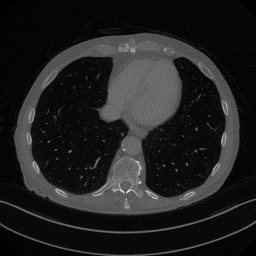

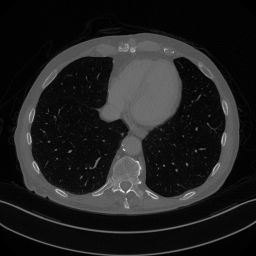

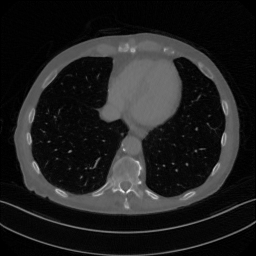

pred_psnr: 37.254841327667236
origin_psnr: 38.403611183166504
pred_ssim tensor(0.9961, device='cuda:0')
origin_ssim tensor(0.9970, device='cuda:0')


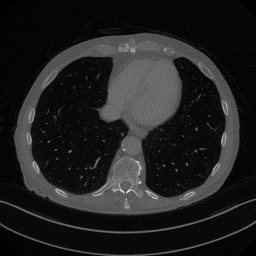

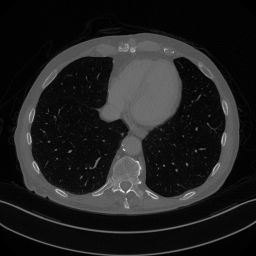

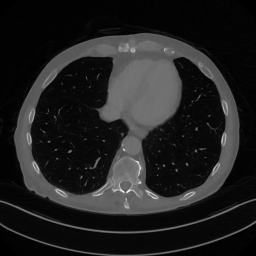

saved_file/ssim_model_10.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.469815161744904 tensor(0.9975, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 37.508904367196756 tensor(0.9970, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_20.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.898063157447844 tensor(0.9976, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 37.977705998498884 tensor(0.9973, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_30.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.83787140012241 tensor(0.9976, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.251977349891035 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_40.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.127149154024885 tensor(0.9977, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.219935905737955 tensor(0.9974, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_50.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.0113734999537 tensor(0.9976, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.35331265652766 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_60.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.38698889003507 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.332344059084285 tensor(0.9975, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_70.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 39.91279461991198 tensor(0.9975, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.54656687330027 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_80.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.35848135277346 tensor(0.9978, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.528833486994756 tensor(0.9976, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_90.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.22571785368394 tensor(0.9977, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.62626790218666 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')
saved_file/ssim_model_100.pth


  0%|          | 0/33 [00:00<?, ?it/s]

test 40.176719336455314 tensor(0.9977, device='cuda:0') 36.196819067907875 tensor(0.9941, device='cuda:0')


  0%|          | 0/39 [00:00<?, ?it/s]

val 38.66559053249046 tensor(0.9977, device='cuda:0') 31.899025502752085 tensor(0.9894, device='cuda:0')


In [15]:
def test_ssim():
    path = 'saved_file/ssim_model_100.pth'
    #model.load_state_dict(torch.load(path))
    dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
    example,target,_,__ = dataset[6]
    example = example.to(device)
    output = model(example).detach().to('cpu')

    # print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
    # print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
    # print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
    # print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
    # transform = transforms.ToPILImage()
    # example = transform(example[0])
    # target = transform(target[0])
    # res = transform(output[0])
    # example.show()
    # target.show()
    # res.show()
    for i in range(10):
        path = 'saved_file/ssim_model_{}.pth'.format((i+1)*10)
        print(path)
        model.load_state_dict(torch.load(path))
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(dataset)
        print('test',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)
        avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM = test(val_dataset)
        print('val',avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM)

test_ssim()